In [77]:
import warnings
import re
from PIL import Image
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [2]:
warnings.filterwarnings('ignore')

In [3]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

SyntaxError: invalid syntax (<ipython-input-3-4aeb3ef8342a>, line 3)

In [4]:
# display options for pandas dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
# pd.reset_option('display.max_colwidth')

In [5]:
# check directory with movielens data files
# https://grouplens.org/datasets/movielens/
! ls -lh Data/ml-20m

total 1710336
-rwxrwxrwx@ 1 johnsonkuan  staff    10K Oct 17  2016 README.txt
-rwxrwxrwx@ 1 johnsonkuan  staff   309M Oct 17  2016 genome-scores.csv
-rwxrwxrwx@ 1 johnsonkuan  staff    18K Oct 17  2016 genome-tags.csv
-rwxrwxrwx@ 1 johnsonkuan  staff   557K Oct 17  2016 links.csv
-rwxrwxrwx@ 1 johnsonkuan  staff   1.3M Mar 31  2015 movies.csv
-rwxrwxrwx@ 1 johnsonkuan  staff   509M Mar 31  2015 ratings.csv
-rwxrwxrwx@ 1 johnsonkuan  staff    16M Mar 31  2015 tags.csv


In [13]:
# quickly check out data
! head -10 Data/ml-20m/movies.csv

movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
6,Heat (1995),Action|Crime|Thriller
7,Sabrina (1995),Comedy|Romance
8,Tom and Huck (1995),Adventure|Children
9,Sudden Death (1995),Action


In [25]:
# quickly check out data
! head -2 Data/wiki_movie_plots_deduped.csv

Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
1901,Kansas Saloon Smashers,American,Unknown,,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Smashers,"A bartender is working at a saloon, serving drinks to customers. After he fills a stereotypically Irish man's bucket with beer, Carrie Nation and her followers burst inside. They assault the Irish man, pulling his hat over his eyes and then dumping the beer over his head. The group then begin wrecking the bar, smashing the fixtures, mirrors, and breaking the cash register. The bartender then sprays seltzer water in Nation's face before a group of policemen appear and order everybody to leave.[1]"


In [26]:
# quickly check out data
! head -10 Data/ml-20m/genome-scores.csv

movieId,tagId,relevance
1,1,0.025000000000000022
1,2,0.025000000000000022
1,3,0.057750000000000024
1,4,0.09675
1,5,0.14675
1,6,0.21700000000000003
1,7,0.067
1,8,0.26275000000000004
1,9,0.262


In [27]:
# quickly check out data
! head -10 Data/ml-20m/genome-tags.csv

tagId,tag
1,007
2,007 (series)
3,18th century
4,1920s
5,1930s
6,1950s
7,1960s
8,1970s
9,1980s


In [6]:
# movie titles
mv_genres = pd.read_csv('Data/ml-20m/movies.csv')

In [7]:
# movie tags
mv_tags = pd.read_csv('Data/ml-20m/genome-scores.csv')

In [8]:
# movie tag descriptions
mv_tags_desc = pd.read_csv('Data/ml-20m/genome-tags.csv')

In [9]:
# clean title in movies.csv file
def movie_title_clean(title):
  
  # search title for (year) pattern
  s = re.search('\(([^)]+)', title)

  # if pattern exists, remove from string
  year = 9999
  if s:

    title = title[:s.span()[0]].strip()
    year = s.group(1)
  
    # check if year is actual year
    if str(year).isdigit():
      year = int(year)
    else:
      year = 9999  
  
  # if ', The' or ', A' is a the end of the string, move it to the front
  # e.g. change "Illusionist, The" to "The Illusionist"
  if title[-5:] == ', The':
    title = 'The ' + title[:-5]
  elif title[-4:] == ', An':
    title = 'An ' + title[:-4]
  elif title[-3:] == ', A':
    title = 'A ' + title[:-3]
    
  return title, year

In [10]:
# clean title and extract release year
mv_genres['title'] = mv_genres['title'].str.strip()
mv_genres['Title_Year'] = mv_genres['title'].map(movie_title_clean)
mv_genres['Title'] = mv_genres['Title_Year'].apply(lambda x: x[0])
mv_genres['Release Year'] = mv_genres['Title_Year'].apply(lambda x: x[1])

In [11]:
mv_genres.head()

,movieId,title,genres,Title_Year,Title,Release Year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"(Toy Story, 1995)",Toy Story,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,"(Jumanji, 1995)",Jumanji,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,"(Grumpier Old Men, 1995)",Grumpier Old Men,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"(Waiting to Exhale, 1995)",Waiting to Exhale,1995
4,5,Father of the Bride Part II (1995),Comedy,"(Father of the Bride Part II, 1995)",Father of the Bride Part II,1995


In [12]:
# create binary indicators for each genre
# source: https://datascience.stackexchange.com/questions/14847/multiple-categorical-values-for-a-single-feature-how-to-convert-them-to-binary-u
mv_genres_stack = mv_genres[mv_genres['genres'] != '(no genres listed)'].set_index('movieId').genres.str.split('|', expand = True).stack()
mv_genres_explode = pd.get_dummies(mv_genres_stack, prefix = 'g').groupby(level = 0).sum().reset_index()
del mv_genres_stack

In [13]:
# genre vector (binary string)
mv_genres_explode['genre_vector'] = mv_genres_explode.iloc[:,1:].values.tolist()

In [19]:
# check out genre vector
mv_genres_explode.head(3)

,movieId,g_Action,g_Adventure,g_Animation,g_Children,g_Comedy,g_Crime,g_Documentary,g_Drama,g_Fantasy,g_Film-Noir,g_Horror,g_IMAX,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Thriller,g_War,g_Western,genre_vector
0,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [17]:
# append genre vector
mv_genres = mv_genres.merge(mv_genres_explode[['movieId','genre_vector']], on = 'movieId', how = 'left')

In [20]:
# check out genre dataframe with genre vector
mv_genres.head()

,movieId,title,genres,Title_Year,Title,Release Year,genre_vector
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"(Toy Story, 1995)",Toy Story,1995,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,"(Jumanji, 1995)",Jumanji,1995,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,Grumpier Old Men (1995),Comedy|Romance,"(Grumpier Old Men, 1995)",Grumpier Old Men,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"(Waiting to Exhale, 1995)",Waiting to Exhale,1995,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ..."
4,5,Father of the Bride Part II (1995),Comedy,"(Father of the Bride Part II, 1995)",Father of the Bride Part II,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Q1: How many tags do we need or each movie?

In [57]:
# number of tags
len(np.unique(mv_tags_desc.tagId.values))

1128

In [58]:
# number of movies
len(np.unique(mv_tags.movieId.values))

10381

In [59]:
# number of movie, tag pairs
len(mv_tags)

11709768

In [35]:
# join dataframes to get tag description and movie title name all in one table
mv_tags_denorm = mv_tags.merge(mv_tags_desc, on = 'tagId').merge(mv_genres, on = 'movieId')

# for each movie, compute the relevance rank of tags so we can eventually rank order tags for each movie
mv_tags_denorm['relevance_rank'] = mv_tags_denorm.groupby("movieId")["relevance"].rank(method = "first", ascending = False).astype('int64')

In [63]:
# check out an example of top tags for a movie
mv_tags_denorm[mv_tags_denorm.Title == 'Remember the Titans'][['movieId','Title','tag','relevance','relevance_rank']].sort_values(by = 'relevance', ascending = False).head(10)

,movieId,Title,tag,relevance,relevance_rank
3896511,3916,Remember the Titans,football,0.99600,1
3897070,3916,Remember the Titans,sports,0.98600,2
3896944,3916,Remember the Titans,race issues,0.97625,3
3896498,3916,Remember the Titans,feel good movie,0.96200,4
3896226,3916,Remember the Titans,based on true story,0.95175,5
3896499,3916,Remember the Titans,feel-good,0.94825,6
3896221,3916,Remember the Titans,based on a true story,0.93975,7
3896660,3916,Remember the Titans,inspiring,0.93650,8
3896614,3916,Remember the Titans,high school,0.93025,9
3896659,3916,Remember the Titans,inspirational,0.92550,10


In [55]:
# compute median relevance score for each relevance rank
mv_tags_rank_agg = mv_tags_denorm.groupby('relevance_rank')['relevance'].median().reset_index(name = 'relevance_median').head(100)

# compute percent change of median relevance score as we go down in rank
mv_tags_rank_agg['relevance_median_pct_chg'] = mv_tags_rank_agg['relevance_median'].pct_change()

Text(0.5, 1.0, 'Box Plot: Tag Relevance Score by Rank')

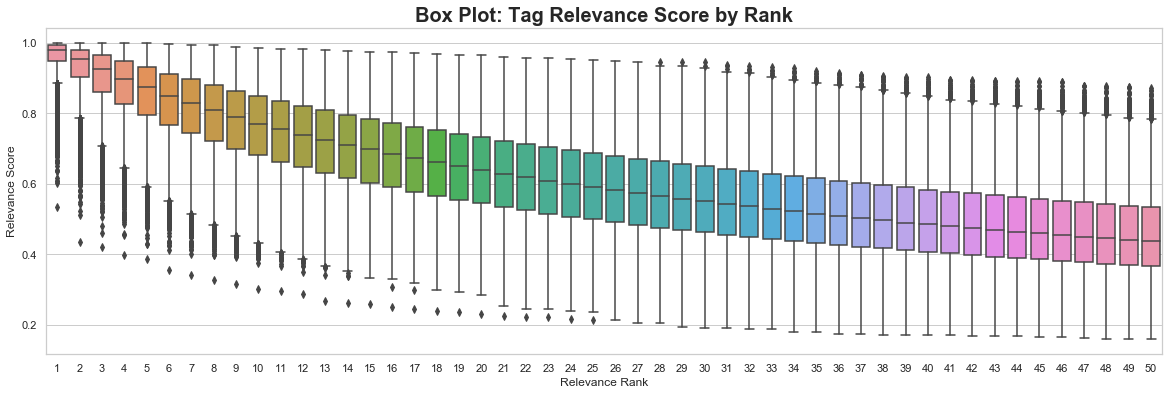

In [65]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(20, 6))

ax = sns.boxplot(x = "relevance_rank", y = "relevance", data = mv_tags_denorm[mv_tags_denorm.relevance_rank <= 50], showfliers = True)
ax.set(ylabel = "Relevance Score")
ax.set(xlabel = "Relevance Rank")
plt.title("Box Plot: Tag Relevance Score by Rank", fontsize = 20, weight = 'bold')

Text(0.5, 1.0, '% Change in Tag Relevance Score by Rank')

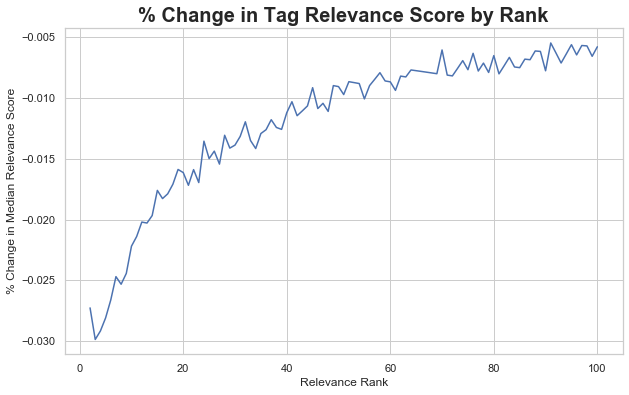

In [67]:
f, ax = plt.subplots(figsize=(10, 6))

ax = sns.lineplot(x="relevance_rank", y="relevance_median_pct_chg", data = mv_tags_rank_agg)
ax.set(ylabel = "% Change in Median Relevance Score")
ax.set(xlabel = "Relevance Rank")
plt.title("% Change in Tag Relevance Score by Rank", fontsize = 20, weight = 'bold')

In [39]:
# flatten tags table to get a list of top 100 tags for each movie
mv_tags_list = mv_tags_denorm[mv_tags_denorm.relevance_rank <= 100].groupby(['movieId','Title'])['tag'].apply(lambda x: ','.join(x)).reset_index()
mv_tags_list['tag_list'] = mv_tags_list.tag.map(lambda x: x.split(','))

In [69]:
mv_tags_list.head(1)

,movieId,Title,tag,tag_list
0,1,Toy Story,"3d,action,adventure,affectionate,animal movie,animals,animated,animation,based on book,cartoon,catastrophe,cgi,chase,childhood,children,classic,clever,colourful,comedy,computer animation,cool,creativity,cute,cute!,destiny,dialogue,disney,disney animated feature,entertaining,excellent,excellent script,exciting,fairy tale,family,fantasy,fantasy world,fast paced,feel good movie,feel-good,friendship,fun,fun movie,funny,good,good acting,good soundtrack,good story,good versus evil,goofy,great,great ending,great movie,happy ending,heartwarming,highly quotable,humor,humorous,imagination,imdb top 250,intense,interesting,kids,kids and family,light,mentor,monsters,movielens top pick,nostalgic,original,original plot,oscar,oscar (best animated feature),oscar (best directing),oscar (best effects - visual effects),oscar winner,pg-13,pixar,pixar animation,quotable,redemption,runaway,sentimental,simple,space,story,storytelling,suspense,sweet,talking animals,talky,technology,touching,toys,transformation,unlikely friendships,very funny,very good,visual,whimsical,witty","[3d, action, adventure, affectionate, animal movie, animals, animated, animation, based on book, cartoon, catastrophe, cgi, chase, childhood, children, classic, clever, colourful, comedy, computer animation, cool, creativity, cute, cute!, destiny, dialogue, disney, disney animated feature, entertaining, excellent, excellent script, exciting, fairy tale, family, fantasy, fantasy world, fast paced, feel good movie, feel-good, friendship, fun, fun movie, funny, good, good acting, good soundtrack, good story, good versus evil, goofy, great, great ending, great movie, happy ending, heartwarming, highly quotable, humor, humorous, imagination, imdb top 250, intense, interesting, kids, kids and family, light, mentor, monsters, movielens top pick, nostalgic, original, original plot, oscar, oscar (best animated feature), oscar (best directing), oscar (best effects - visual effects), oscar winner, pg-13, pixar, pixar animation, quotable, redemption, runaway, sentimental, simple, space, story, storytelling, suspense, sweet, talking animals, talky, technology, touching, toys, transformation, unlikely friendships, very funny, very good, visual, whimsical, witty]"


In [43]:
pd.set_option('display.max_colwidth', -1)

mv_tags_list.loc[mv_tags_list.Title == 'Good Will Hunting', ['movieId','Title','tag_list']]

,movieId,Title,tag_list
1498,1704,Good Will Hunting,"[bittersweet, boston, cerebral, character study, childhood, classic, clever, college, coming of age, complex, complex characters, corruption, courage, depression, destiny, dialogue, dialogue driven, drama, dramatic, drinking, earnest, emotional, excellent, excellent script, exceptional acting, existentialism, feel good movie, feel-good, foul language, friendship, genius, good, good acting, good dialogue, good soundtrack, good story, great, great acting, great dialogue, great ending, great movie, happy ending, heartwarming, highly quotable, honest, hunting, idealism, imdb top 250, inspirational, inspiring, intellectual, intelligent, intense, interesting, life, life philosophy, literature, loneliness, love, love story, math, mathematics, mentor, narrated, original, original plot, oscar, oscar (best actor), oscar (best actress), oscar (best directing), oscar (best picture), oscar (best supporting actor), oscar (best supporting actress), oscar (best writing - screenplay written directly for the screen), oscar winner, pg-13, philosophy, plot, poignant, psychiatry, psychology, quotable, rags to riches, realistic, redemption, reflective, relationships, sappy, sentimental, social commentary, story, storytelling, suprisingly clever, talky, thought-provoking, touching, underdog, unlikely friendships, very good, writing]"


# Q2: How do we use tags to measure the similarity between movies?

In [79]:
# compute Jaccard Index to get most similar movies to target movie

pd.reset_option('display.max_colwidth')

target_movie = 'Interstellar'

target_tag_list = mv_tags_list[mv_tags_list.Title == target_movie].tag_list.values[0]
mv_tags_list_sim = mv_tags_list[['movieId','Title','tag_list','tag']]
mv_tags_list_sim['jaccard_sim'] = mv_tags_list_sim.tag_list.map(lambda x: len(set(x).intersection(set(target_tag_list))) / len(set(x).union(set(target_tag_list))))
print(f'Movies most similar to {target_movie} based on tags:')
text = ','.join(mv_tags_list_sim.sort_values(by = 'jaccard_sim', ascending = False).head(25)['tag'].values)
mv_tags_list_sim.sort_values(by = 'jaccard_sim', ascending = False).head(10)

Movies most similar to Interstellar based on tags:


,movieId,Title,tag_list,tag,jaccard_sim
10046,109487,Interstellar,"[70mm, adventure, amazing cinematography, amaz...","70mm,adventure,amazing cinematography,amazing ...",1.000000
8055,52328,Sunshine,"[alien, aliens, allegory, amazing cinematograp...","alien,aliens,allegory,amazing cinematography,a...",0.503759
9803,101864,Oblivion,"[action, adapted from:comic, adventure, alien,...","action,adapted from:comic,adventure,alien,alie...",0.503759
9915,104841,Gravity,"[3d, action, allegory, amazing cinematography,...","3d,action,allegory,amazing cinematography,amaz...",0.470588
1452,1653,Gattaca,"[allegory, alone in the world, amazing cinemat...","allegory,alone in the world,amazing cinematogr...",0.459854
1390,1584,Contact,"[adapted from:book, adventure, alien, alien in...","adapted from:book,adventure,alien,alien invasi...",0.459854
10220,114935,Predestination,"[absurd, adaptation, allegory, alternate endin...","absurd,adaptation,allegory,alternate endings,a...",0.449275
9676,97752,Cloud Atlas,"[1930s, 19th century, adaptation, adapted from...","1930s,19th century,adaptation,adapted from:boo...",0.428571
3864,4370,A.I. Artificial Intelligence,"[adventure, alien, aliens, allegory, alone in ...","adventure,alien,aliens,allegory,alone in the w...",0.428571
8696,68237,Moon,"[androids, artificial intelligence, astronauts...","androids,artificial intelligence,astronauts,at...",0.428571


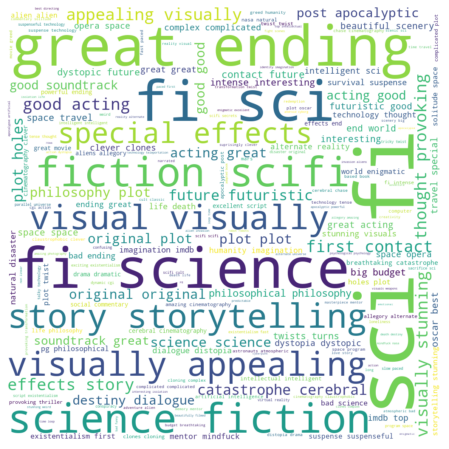

In [80]:
plt.rcParams["figure.figsize"] = (15,10)

# Generate a word cloud image
wordcloud = WordCloud(width = 1024, height = 1024, background_color = 'white').generate(text)

# Display the generated image:
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [81]:
# corpus of movie tags
mv_tags_corpus = mv_tags_list.tag.values

In [85]:
stop_words = stopwords.words('english')

# tokenize document and clean
def word_tokenize_clean(doc):
  
  # split into lower case word tokens
  tokens = word_tokenize(doc.lower())
  
  # remove tokens that are not alphabetic (including punctuation) and not a stop word
  tokens = [word for word in tokens if word.isalpha() and not word in stop_words]
  
  return tokens

In [86]:
# preprocess corpus of movie tags before feeding it into Doc2Vec model
mv_tags_doc = [TaggedDocument(words=word_tokenize_clean(D), tags=[str(i)]) for i, D in enumerate(mv_tags_corpus)]

In [95]:
# instantiate Doc2Vec model

max_epochs = 50
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm=0) # paragraph vector distributed bag-of-words (PV-DBOW)
  
model.build_vocab(mv_tags_doc)

In [96]:
# train Doc2Vec model
# stochastic (random initialization), so each run will be different unless you specify seed

print('Epoch', end = ': ')
for epoch in range(max_epochs):
  print(epoch, end = ' ')
  model.train(mv_tags_doc,
              total_examples=model.corpus_count,
              epochs=model.epochs)
  # decrease the learning rate
  model.alpha -= 0.0002
  # fix the learning rate, no decay
  model.min_alpha = model.alpha

Epoch: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [97]:
# listing space embeddings
mv_tags_vectors = model.docvecs.vectors_docs

In [98]:
mv_tags_vectors.shape

(10381, 20)

In [99]:
# top similar movies based on cosine similarity

mv = 'Good Will Hunting'

mv_index = mv_tags_list[mv_tags_list["Title"] == mv].index.values[0]

print(mv_tags_vectors[mv_index])

sims = model.docvecs.most_similar(positive = [mv_index], topn = 30)

for i, j in sims:
  print(mv_tags_list.loc[int(i), "Title"].strip())

[ 0.0359128  -0.00471256 -0.8689928   0.55005765  0.2680127  -1.3525741
 -0.52293944  0.16818829  0.67824763 -1.3713334   0.29896903  1.552356
 -0.5289935  -0.08088091  0.19913252 -0.27782422 -1.6430552   1.5271128
 -0.8598932   0.57133925]
Finding Forrester
As Good as It Gets
The Theory of Everything
Dead Poets Society
The Shawshank Redemption
On Golden Pond
Rain Man
Ruby Sparks
Children of a Lesser God
The Sea Inside
Dallas Buyers Club
The Big Chill
Educating Rita
Scent of a Woman
Moneyball
The Hustler
Pay It Forward
Barney's Version
St. Vincent
Charly
Wonder Boys
Still Alice
Almost Famous
Silver Linings Playbook
Cinema Paradiso
Temple Grandin
Return to Paradise
Milk
The Fisher King
I Am Sam


In [103]:
# dimensionality reduction to 2D
mv_tags_vectors_umap = umap.UMAP(n_neighbors = 5,
                          min_dist = 0.001,
                          metric = 'cosine').fit_transform(mv_tags_vectors)

In [104]:
x, y = mv_tags_vectors_umap.T[0], mv_tags_vectors_umap.T[1]

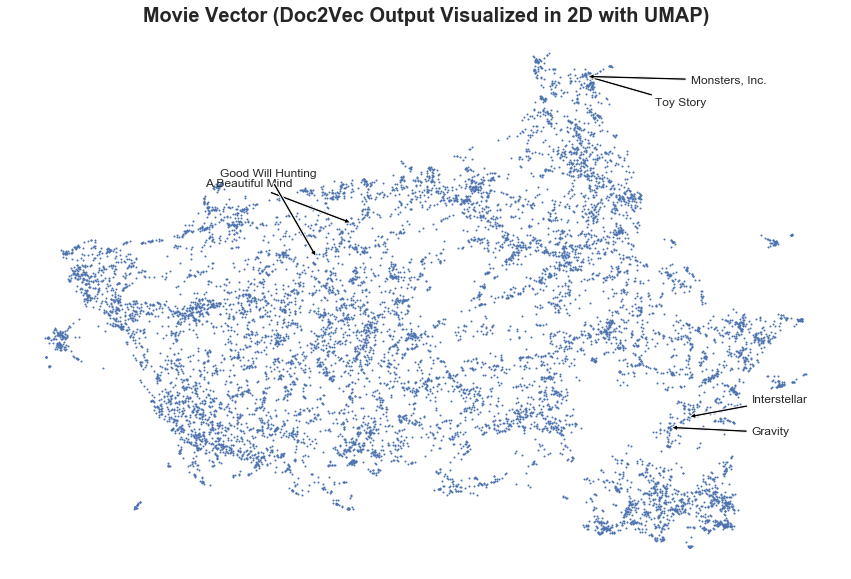

In [105]:
# visualize movie vectors in 2D with UMAP
# label some movies

plt.rcParams["figure.figsize"] = (15,10)
plt.grid(b = None)
plt.axis('off')
plt.scatter(x, y, s = 1)
plt.title('Document Embedding (UMAP)')
plt.xlabel('e1')
plt.ylabel('e2')

mv = 'A Beautiful Mind'
mv_index = mv_tags_list[mv_tags_list["Title"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0]-1, mv_tags_vectors_umap[mv_index, 1]+1),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

mv = 'Good Will Hunting'
mv_index = mv_tags_list[mv_tags_list["Title"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]+2),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

mv = 'Gravity'
mv_index = mv_tags_list[mv_tags_list["Title"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0]+2, mv_tags_vectors_umap[mv_index, 1]),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

mv = 'Interstellar'
mv_index = mv_tags_list[mv_tags_list["Title"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0]+2, mv_tags_vectors_umap[mv_index, 1]+0.5),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

mv = 'Toy Story'
mv_index = mv_tags_list[mv_tags_list["Title"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0]+2, mv_tags_vectors_umap[mv_index, 1]-0.5),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

mv = 'Monsters, Inc.'
mv_index = mv_tags_list[mv_tags_list["Title"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0]+3, mv_tags_vectors_umap[mv_index, 1]+0.025),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

plt.title('Movie Vector (Doc2Vec Output Visualized in 2D with UMAP)', fontsize = 20, weight = 'bold')
plt.show()

# Q3: How do we use tags to generate movie recommendations for a user?

In [110]:
# history of movies the user watched and liked
user_movies = ['Interstellar','Good Will Hunting','Gattaca',
               'Almost Famous','The Shawshank Redemption','Edge of Tomorrow',
               'Jerry Maguire','Forrest Gump','Back to the Future']

# compute user vector as an average of movie vectors seen by that user
user_movie_vector = np.zeros(shape = mv_tags_vectors.shape[1])
for mv in user_movies:
  mv_index = mv_tags_list[mv_tags_list["Title"] == mv].index.values[0]  
  user_movie_vector += mv_tags_vectors[mv_index]

user_movie_vector /= len(user_movies)  

# print(user_movie_vector)
  
#  find movies similar to user vector to generate movie recommendations

print('Movie Recommendations:')

sims = model.docvecs.most_similar(positive = [user_movie_vector], topn = 30)

for i, j in sims:
  movie_sim = mv_tags_list.loc[int(i), "Title"].strip()
  if movie_sim not in user_movies:
    print(movie_sim)

Movie Recommendations:
The Theory of Everything
Cast Away
Dead Poets Society
Charly
Rain Man
Groundhog Day
Pay It Forward
A Beautiful Mind
E.T. the Extra-Terrestrial
Mr. Holland's Opus
On Golden Pond
It's a Wonderful Life
Children of a Lesser God
The Curious Case of Benjamin Button
Star Trek II: The Wrath of Khan
Cinema Paradiso
Mr. Smith Goes to Washington
The Terminal
Her
The World's Fastest Indian
The Truman Show
Star Trek: First Contact
The Family Man

